In this notebook, you will
- Learn how to use `Linop`, `Prox`, and `Alg` to create an `App`
- Create a Fourier compressed sensing `App`

![architecture](https://sigpy.readthedocs.io/en/latest/_images/architecture.pdf)

In [83]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

$$\frac{1}{2} \| P F x - y \|_2^2 + \lambda \| W x \|_1$$

# Linop

https://sigpy.readthedocs.io/en/latest/core_linop.html

In [125]:
x_shape = [256, 256]

F = sp.linop.FFT(x_shape)

<IPython.core.display.Javascript object>


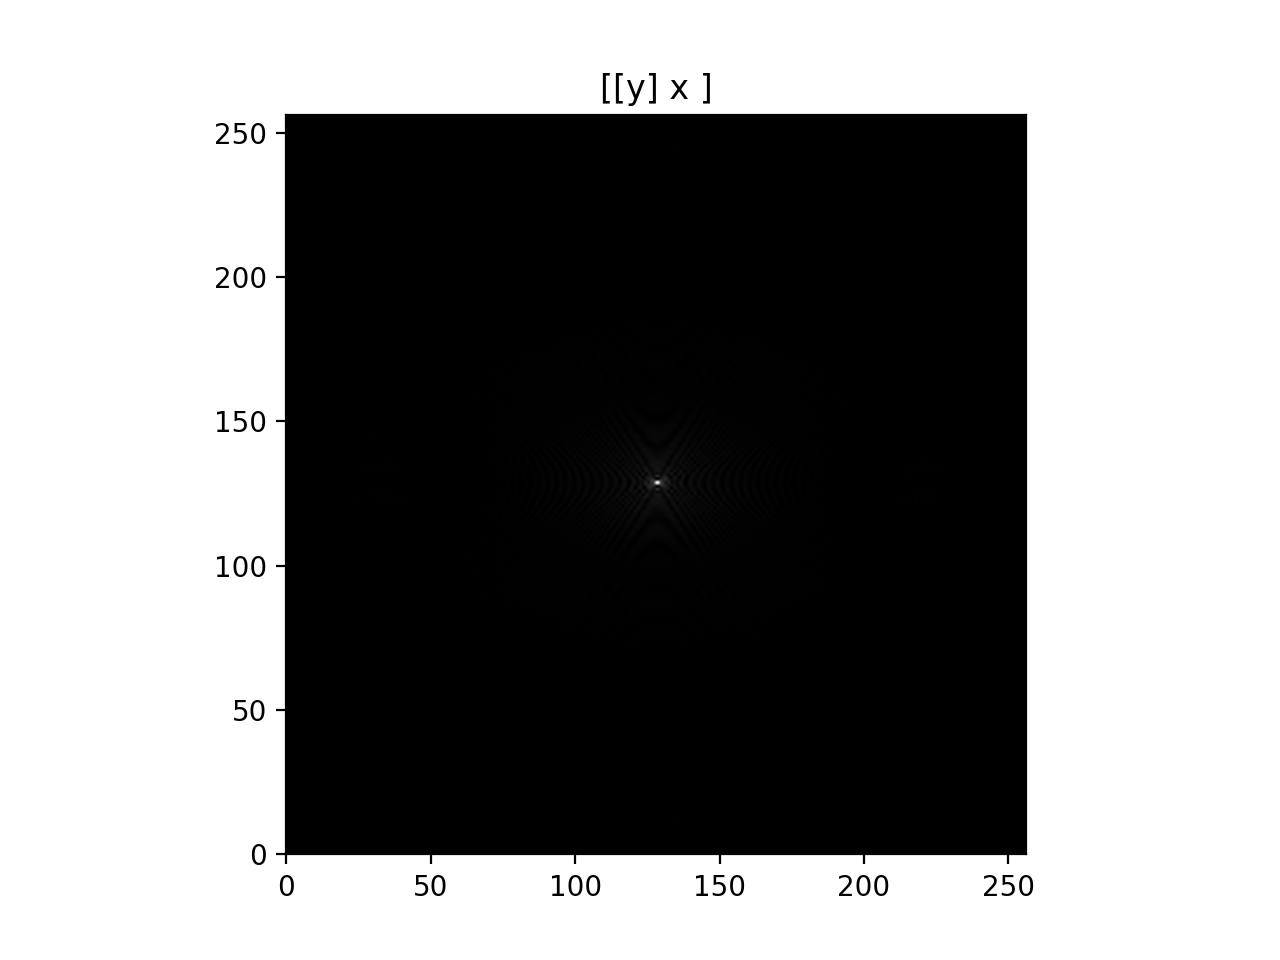

In [126]:
x = mr.shepp_logan(x_shape)
y = F * x # Alternatively can also do F(x)

pl.ImagePlot(y)

## Adjoint

<IPython.core.display.Javascript object>


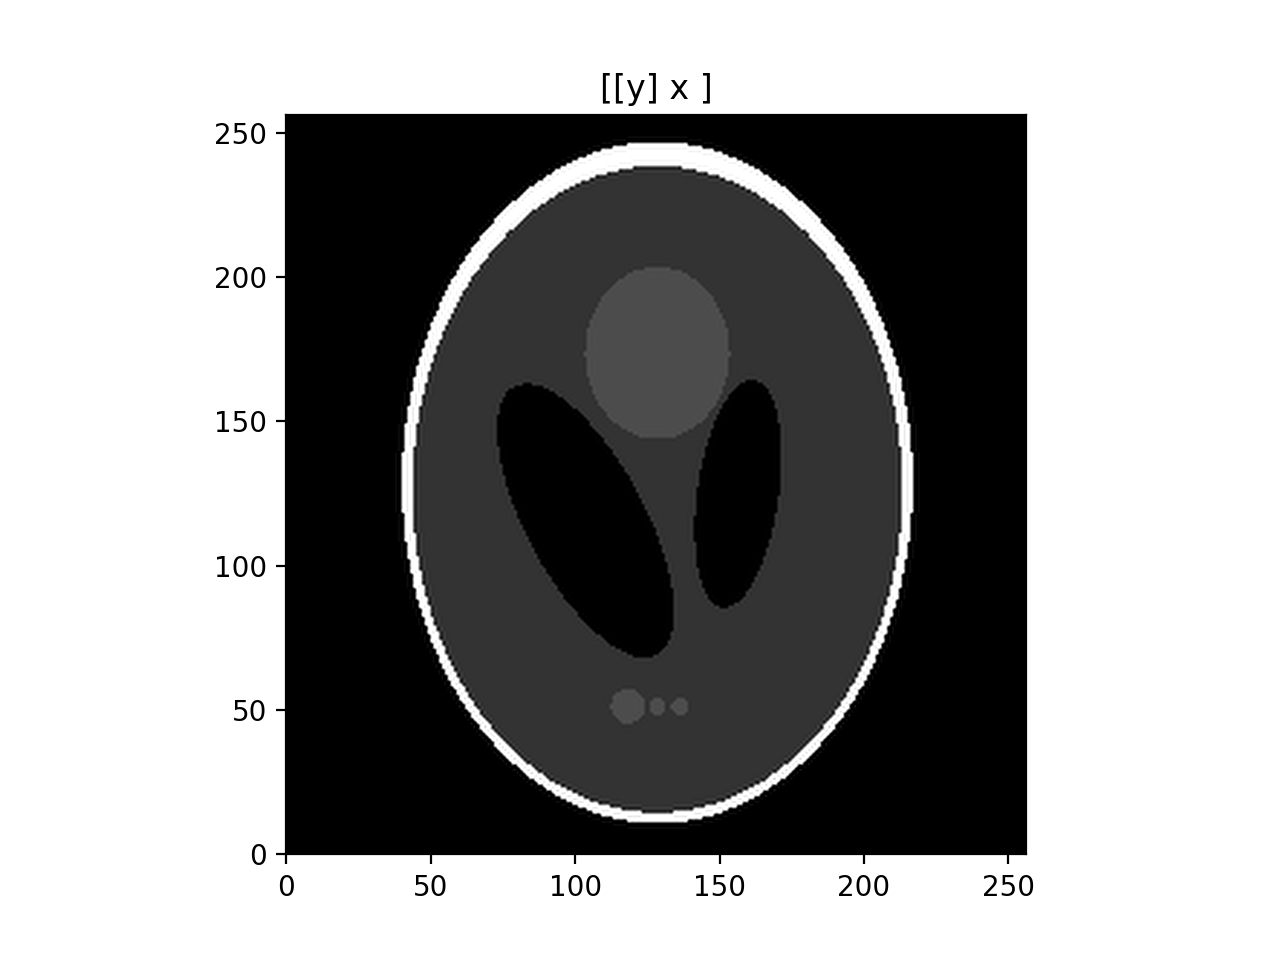

In [86]:
x_hat = F.H * y

pl.ImagePlot(x_hat)

## Chaining

<IPython.core.display.Javascript object>


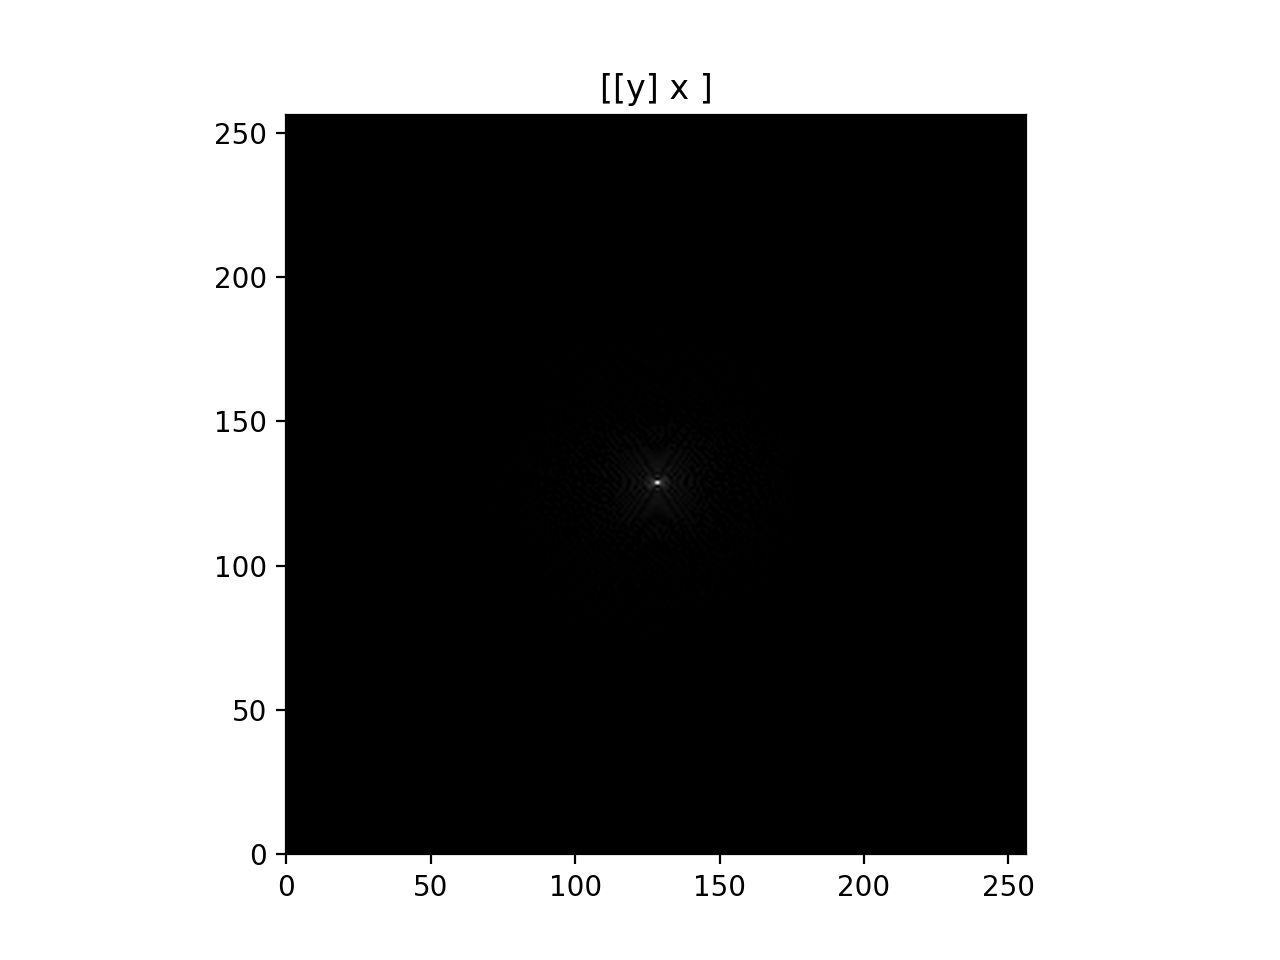

In [87]:
accel = 8
calib = [24, 24]

mask = mr.poisson(img_shape, accel, calib=calib)
P = sp.linop.Multiply(img_shape, mask)

y_u = P * y
pl.ImagePlot(y_u)

<IPython.core.display.Javascript object>


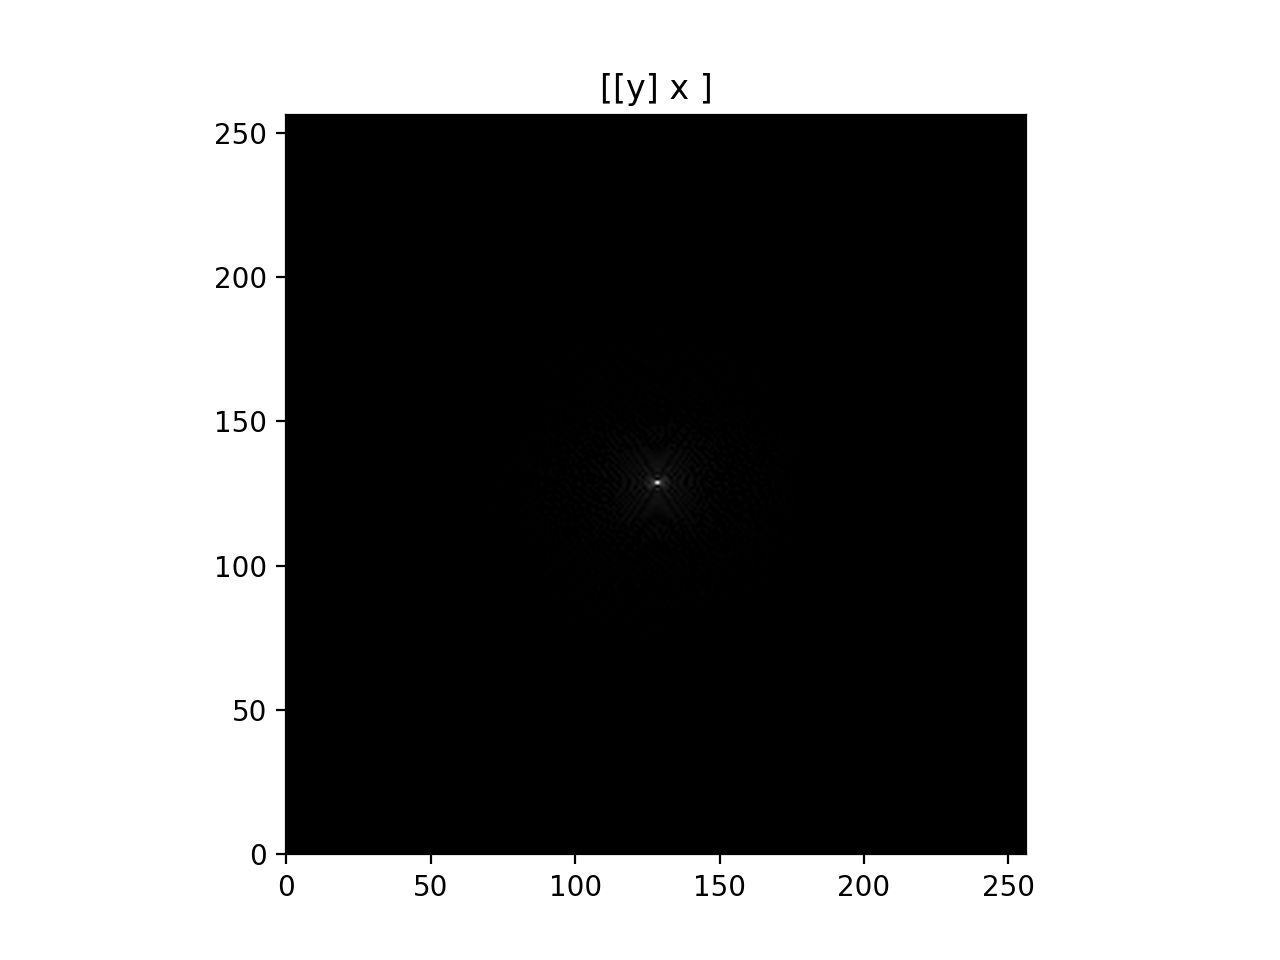

In [26]:
A = P * F

y_u = A * x

pl.ImagePlot(y_u)

<IPython.core.display.Javascript object>


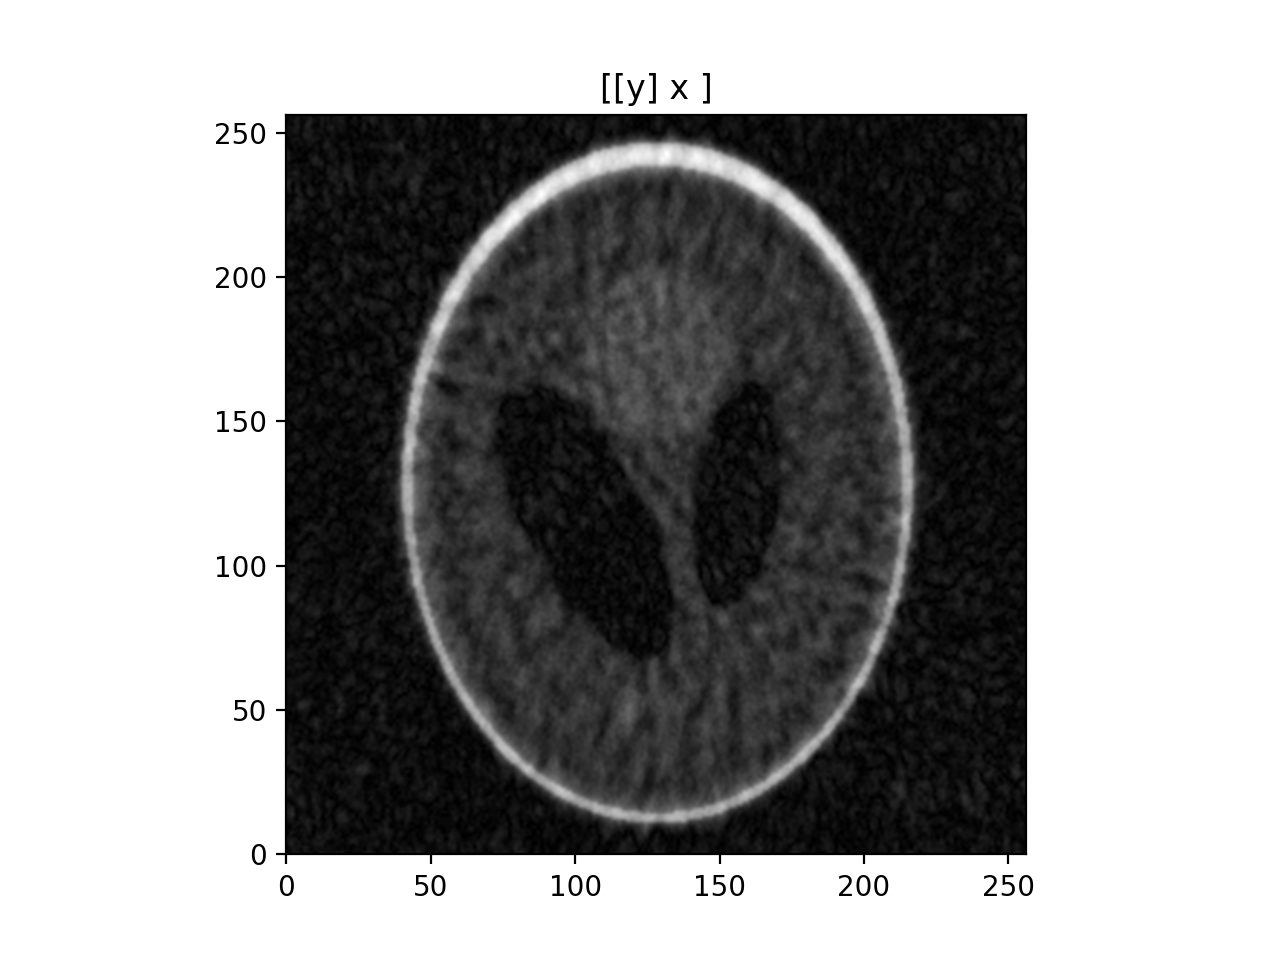

In [88]:
x_u = A.H * y_u

pl.ImagePlot(x_u)

/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dictionary of wavelet coefficients as returned by pywt.wavedecn
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<IPython.core.display.Javascript object>


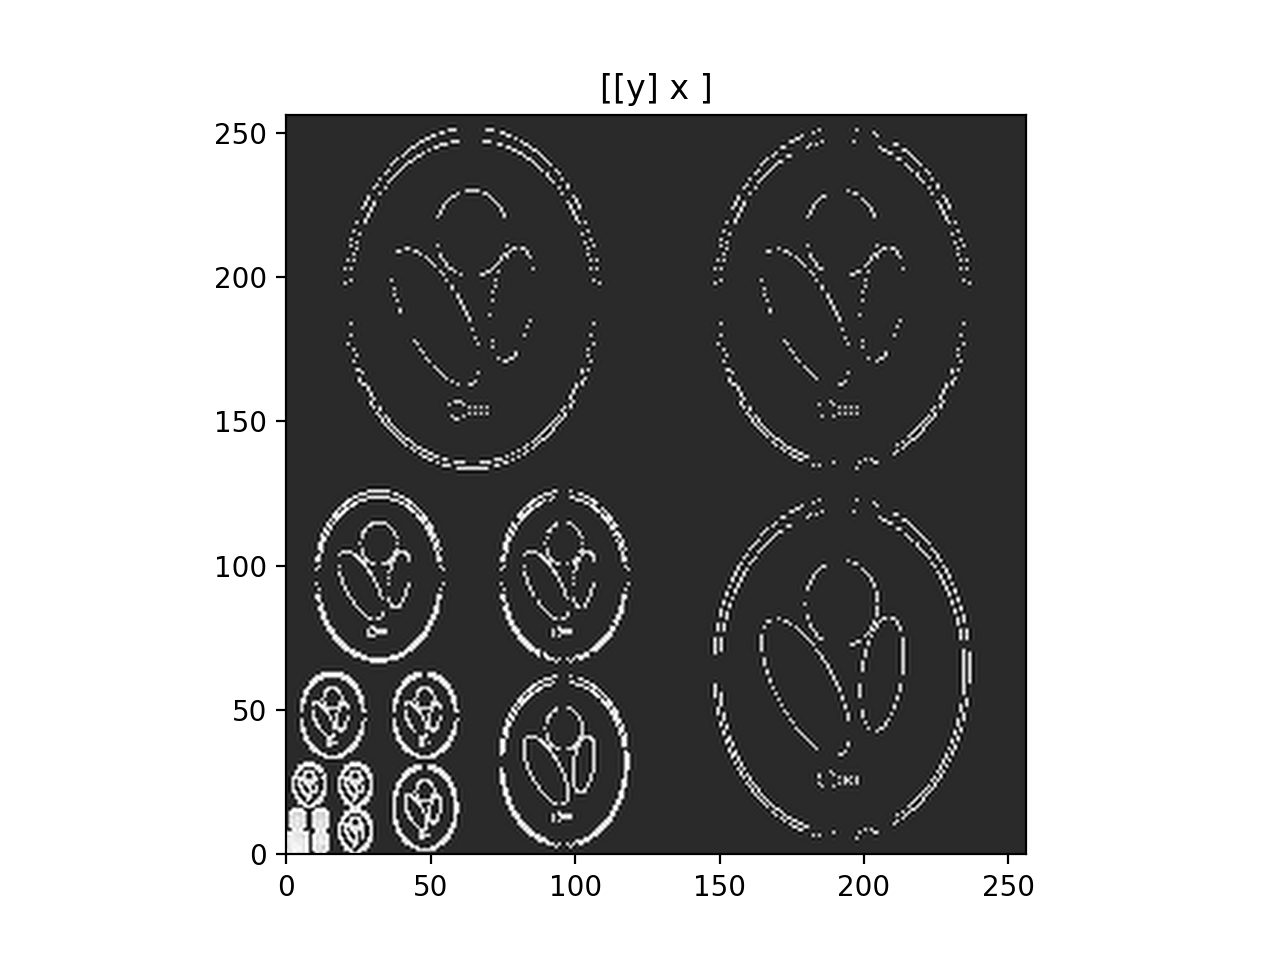

In [89]:
W = sp.linop.Wavelet(img_shape, wave_name='haar')

wav = W * x

pl.ImagePlot(wav)

# Prox

https://sigpy.readthedocs.io/en/latest/core_prox.html

/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dictionary of wavelet coefficients as returned by pywt.wavedecn
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<IPython.core.display.Javascript object>


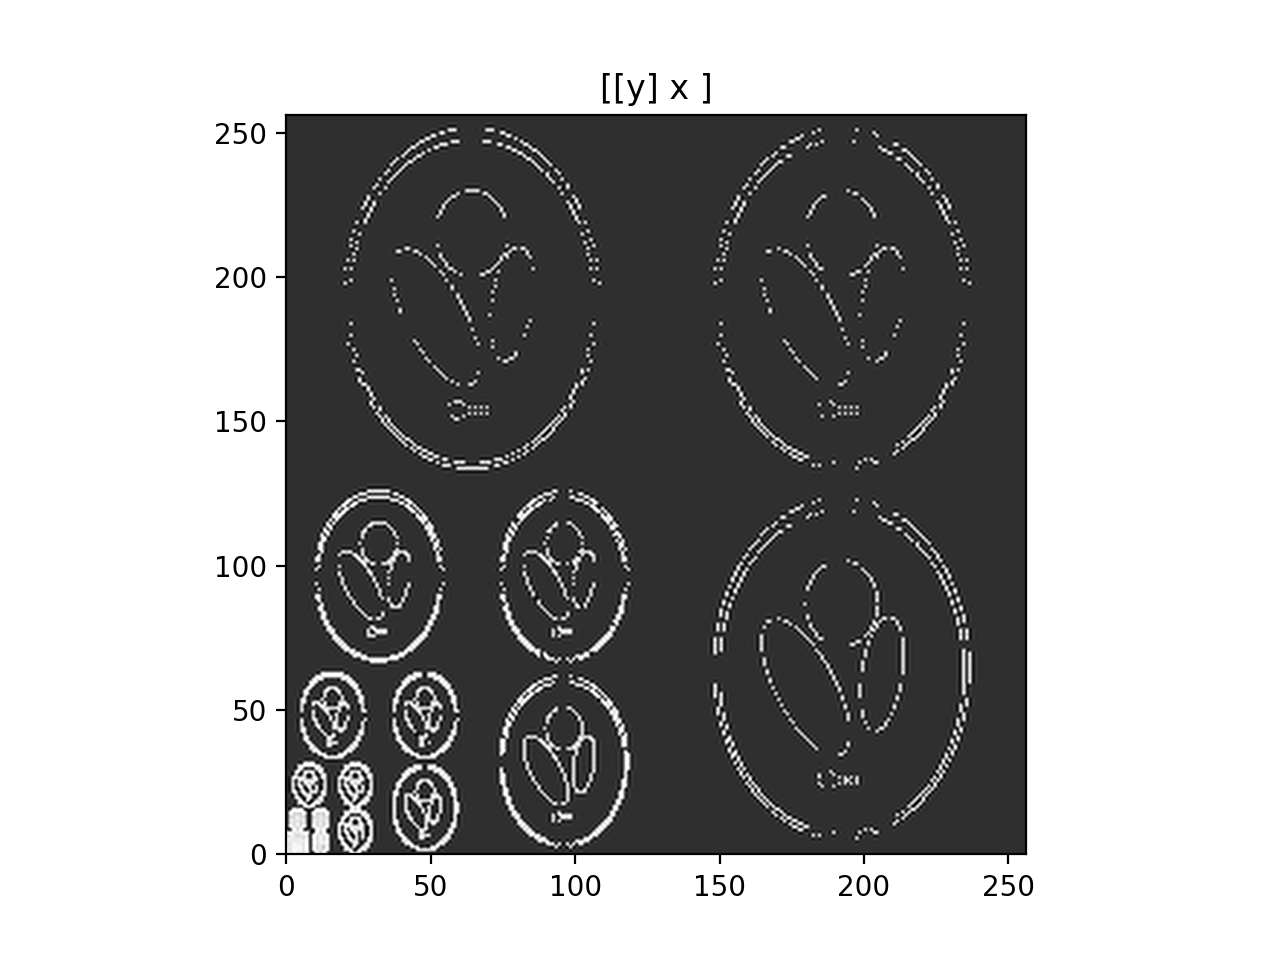

In [97]:
lamda = 0.01
proxg = sp.prox.L1Reg(img_shape, lamda)
proxg = sp.prox.UnitaryTransform(proxg, W)
alpha = 1
x_thresh = prox(alpha, x)

pl.ImagePlot(W * x_thresh)

# Alg

https://sigpy.readthedocs.io/en/latest/core_alg.html

In [107]:
max_iter = 100
alpha = 1

def gradf(x):
    return A.H * (A * x - y)

x_hat = np.zeros(img_shape, np.complex)
alg = sp.alg.GradientMethod(gradf, x_hat, alpha, proxg=proxg, max_iter=max_iter, accelerate=True)

In [108]:
while not alg.done():
    alg.update()

/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dictionary of wavelet coefficients as returned by pywt.wavedecn
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:763: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

<IPython.core.display.Javascript object>


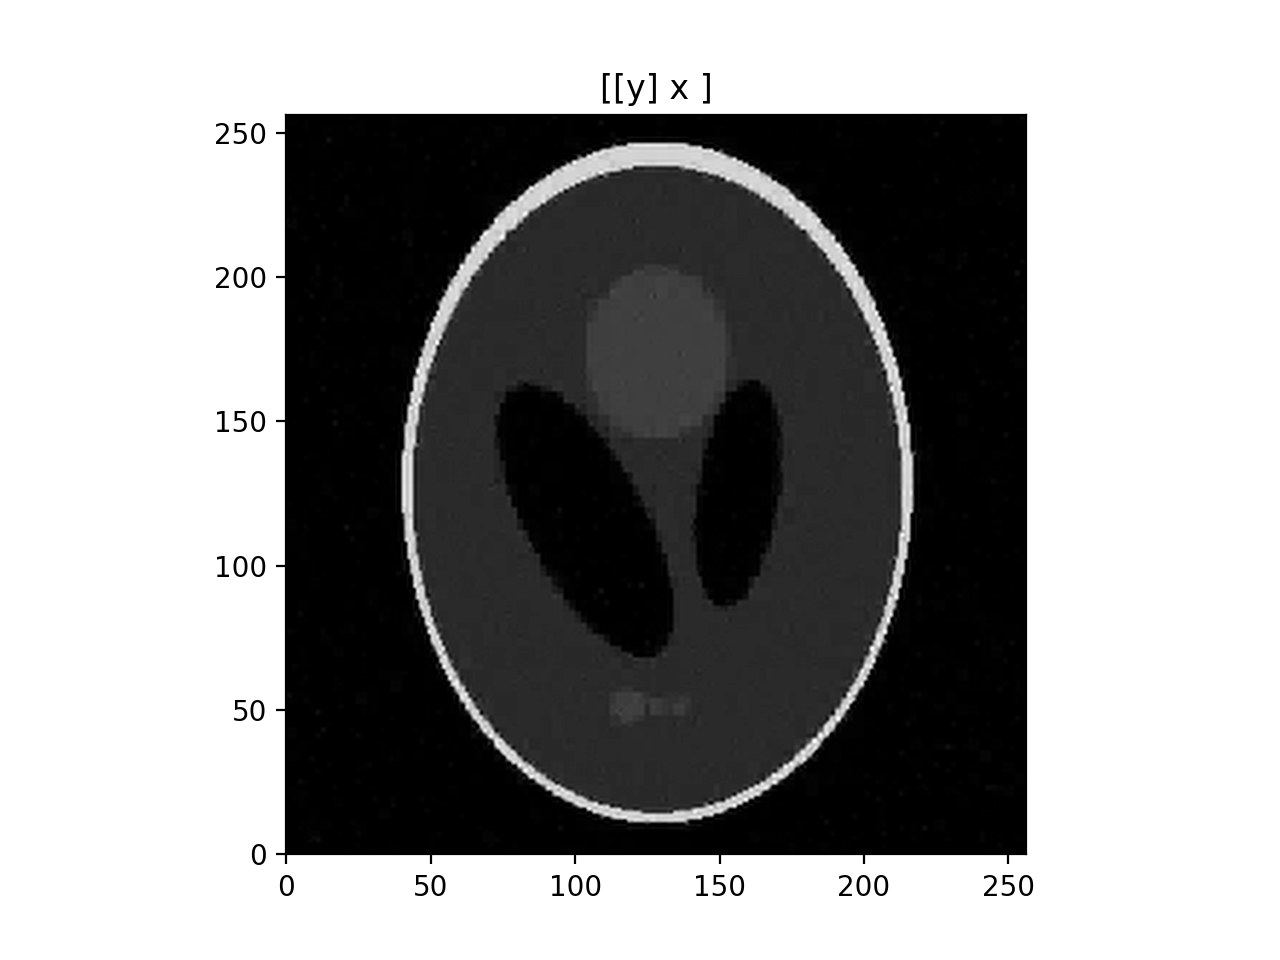

In [109]:
pl.ImagePlot(x_hat)

# App

In [124]:
class FourierCompressedSensing(sp.app.App):
    def __init__(self, y, mask, lamda, max_iter):
        x_shape = y.shape
        
        # 
        F = sp.linop.FFT(x_shape)
        P = sp.linop.Multiply(x_shape, mask)
        A = P * F
        
        proxg = sp.prox.L1Reg(x_shape, lamda)
        proxg = sp.prox.UnitaryTransform(proxg, W)
        
        self.x_hat = np.zeros(x_shape, np.complex)
        alpha = 1
        alg = sp.alg.GradientMethod(gradf, self.x_hat, alpha, proxg=proxg, 
                                    max_iter=max_iter, accelerate=True)
        super().__init__(alg)
        
    def _output(self):
        return self.x_hat

In [122]:
x_hat = FourierCompressedSensing(y, mask, lamda, max_iter).run()

FourierCompressedSensing:   0%|          | 0/100 [00:00<?, ?it/s]/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dictionary of wavelet coefficients as returned by pywt.wavedecn
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/Users/frankong/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:763: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

<IPython.core.display.Javascript object>


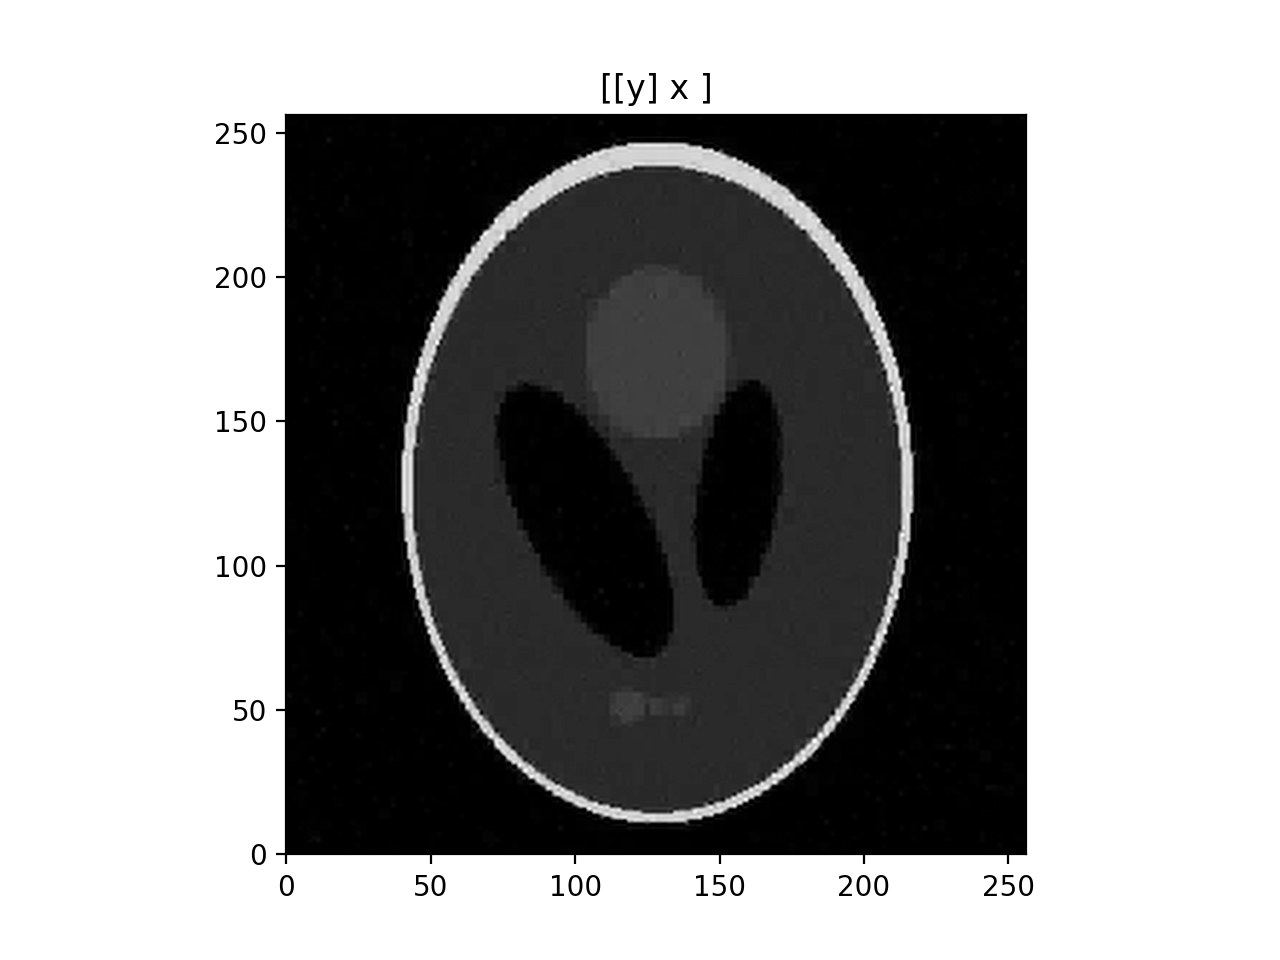

In [123]:
pl.ImagePlot(x_hat)